In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv')
EB00=train[(train['x']==0) & (train['y']==0) & (train['direction']=='EB')].loc[:,['time','congestion']]
EB00['time']=pd.to_datetime(EB00['time'])
EB00.set_index('time',inplace=True)
EB00

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-09-30 10:20:00,43
1991-09-30 10:40:00,47
1991-09-30 11:00:00,40


In [4]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [5]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data,percentage=0.5,size=10,emdtype=EMD,emdsum=1):
    data_pure = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        temp=emd_calculate(data[i-window:i],plots=False,emdtype=emdtype)
        temp_1= reconstruction(temp)
        data_pure= pd.concat([data_pure,pd.Series(temp_1.values[emdsum,:])], axis=1)
    return data_pure.T

In [7]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [8]:
GSPC_pure=create_pure(EB00,size=100)

GSPC_noisy=create_noisy(EB00,size=100)

In [9]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(66, 6529)
(66, 6529)


In [10]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [11]:
keras.backend.clear_session()

In [12]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [13]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
2/2 [==============================] - 1s 477ms/step - loss: 0.0103 - mae: 0.0768 - val_loss: 0.0103 - val_mae: 0.0776
Epoch 2/400
2/2 [==============================] - 1s 390ms/step - loss: 0.0098 - mae: 0.0749 - val_loss: 0.0101 - val_mae: 0.0769
Epoch 3/400
2/2 [==============================] - 1s 345ms/step - loss: 0.0094 - mae: 0.0733 - val_loss: 0.0102 - val_mae: 0.0776
Epoch 4/400
2/2 [==============================] - 1s 345ms/step - loss: 0.0092 - mae: 0.0729 - val_loss: 0.0103 - val_mae: 0.0783
Epoch 5/400
2/2 [==============================] - 1s 344ms/step - loss: 0.0091 - mae: 0.0727 - val_loss: 0.0099 - val_mae: 0.0765
Epoch 6/400
2/2 [==============================] - 1s 353ms/step - loss: 0.0088 - mae: 0.0710 - val_loss: 0.0094 - val_mae: 0.0741
Epoch 7/400
2/2 [==============================] - 1s 355ms/step - loss: 0.0085 - mae: 0.0695 - val_loss: 0.0090 - val_mae: 0.0723
Epoch 8/400
2/2 [==============================] - 1s 351ms/step - loss: 0.0081 - m

In [14]:
modelen_mm.save_weights('tramodel_weights_mm.h5', overwrite=True)  

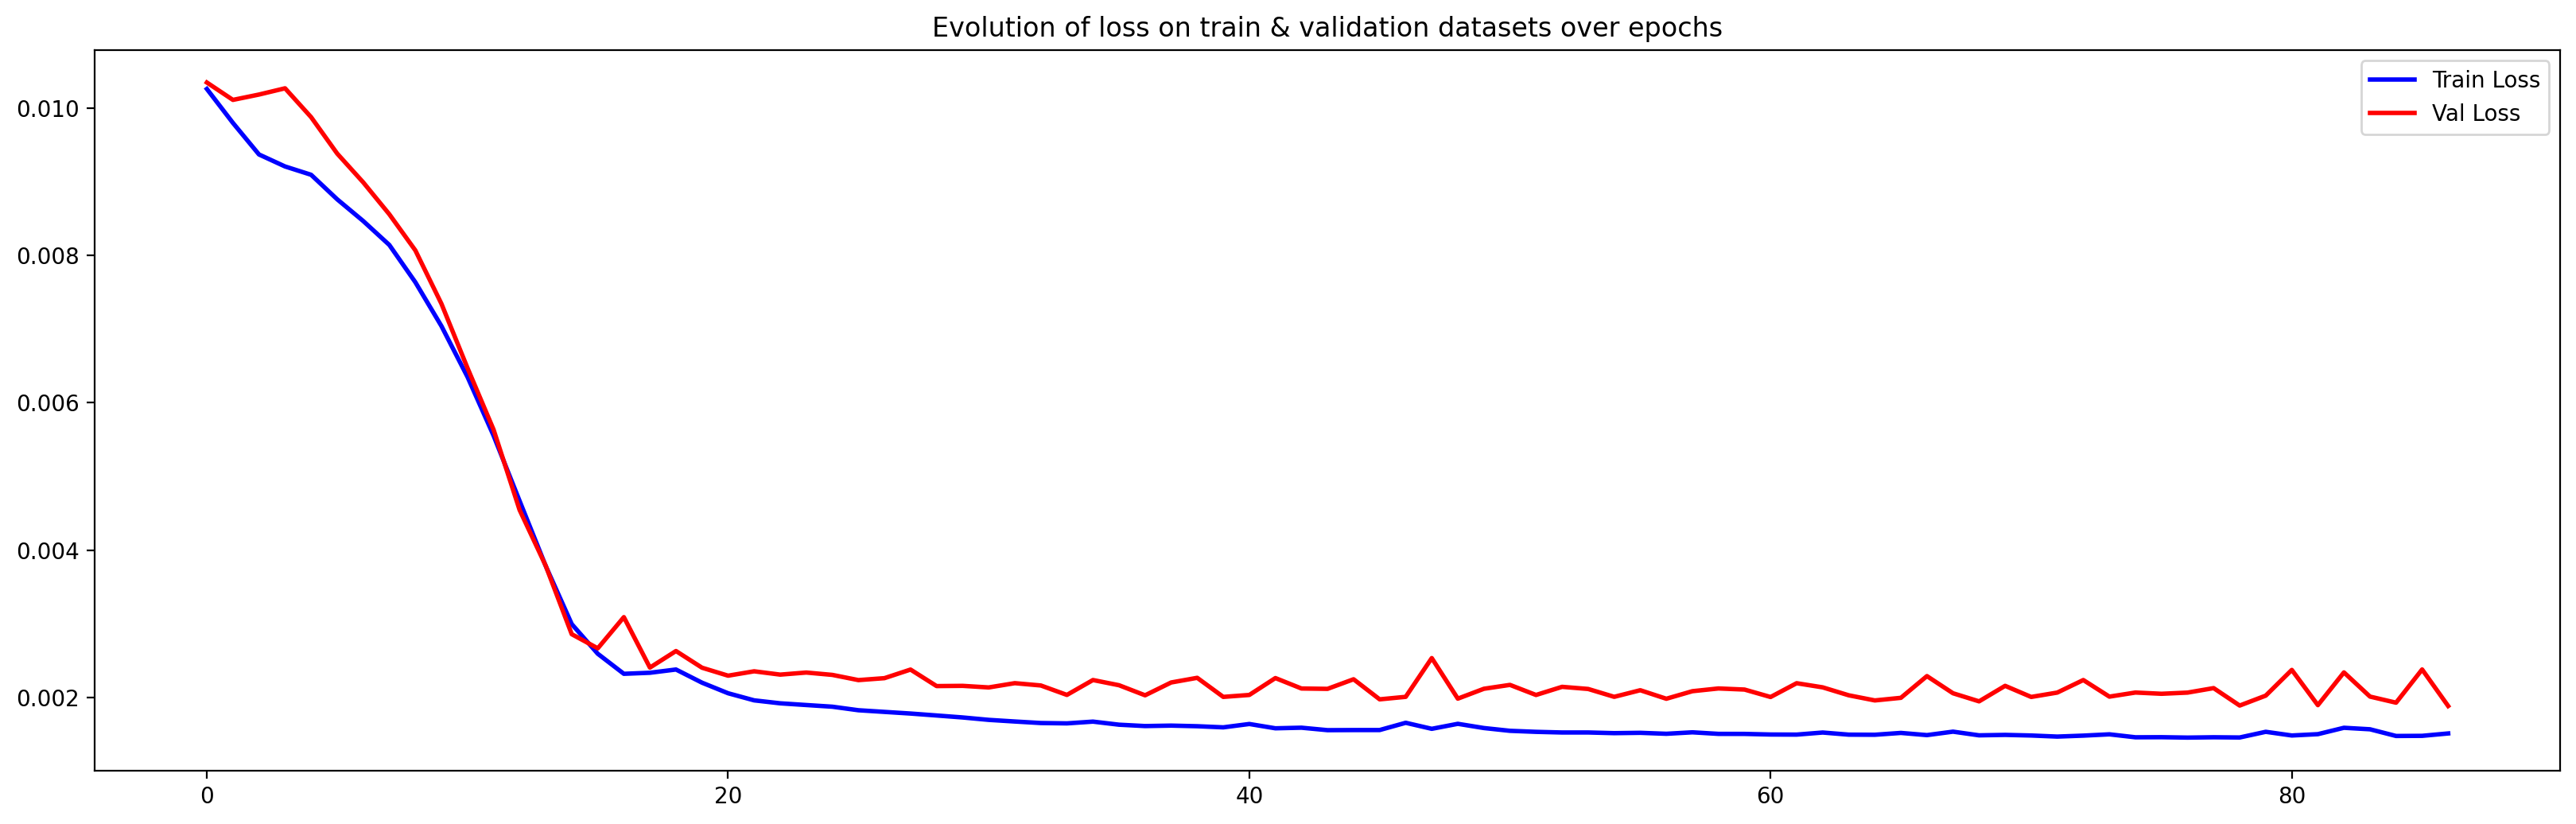

In [15]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [16]:
GSPC_test = EB00
GSPC_test

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-09-30 10:20:00,43
1991-09-30 10:40:00,47
1991-09-30 11:00:00,40


1/1 [==============================] - 0s 127ms/step


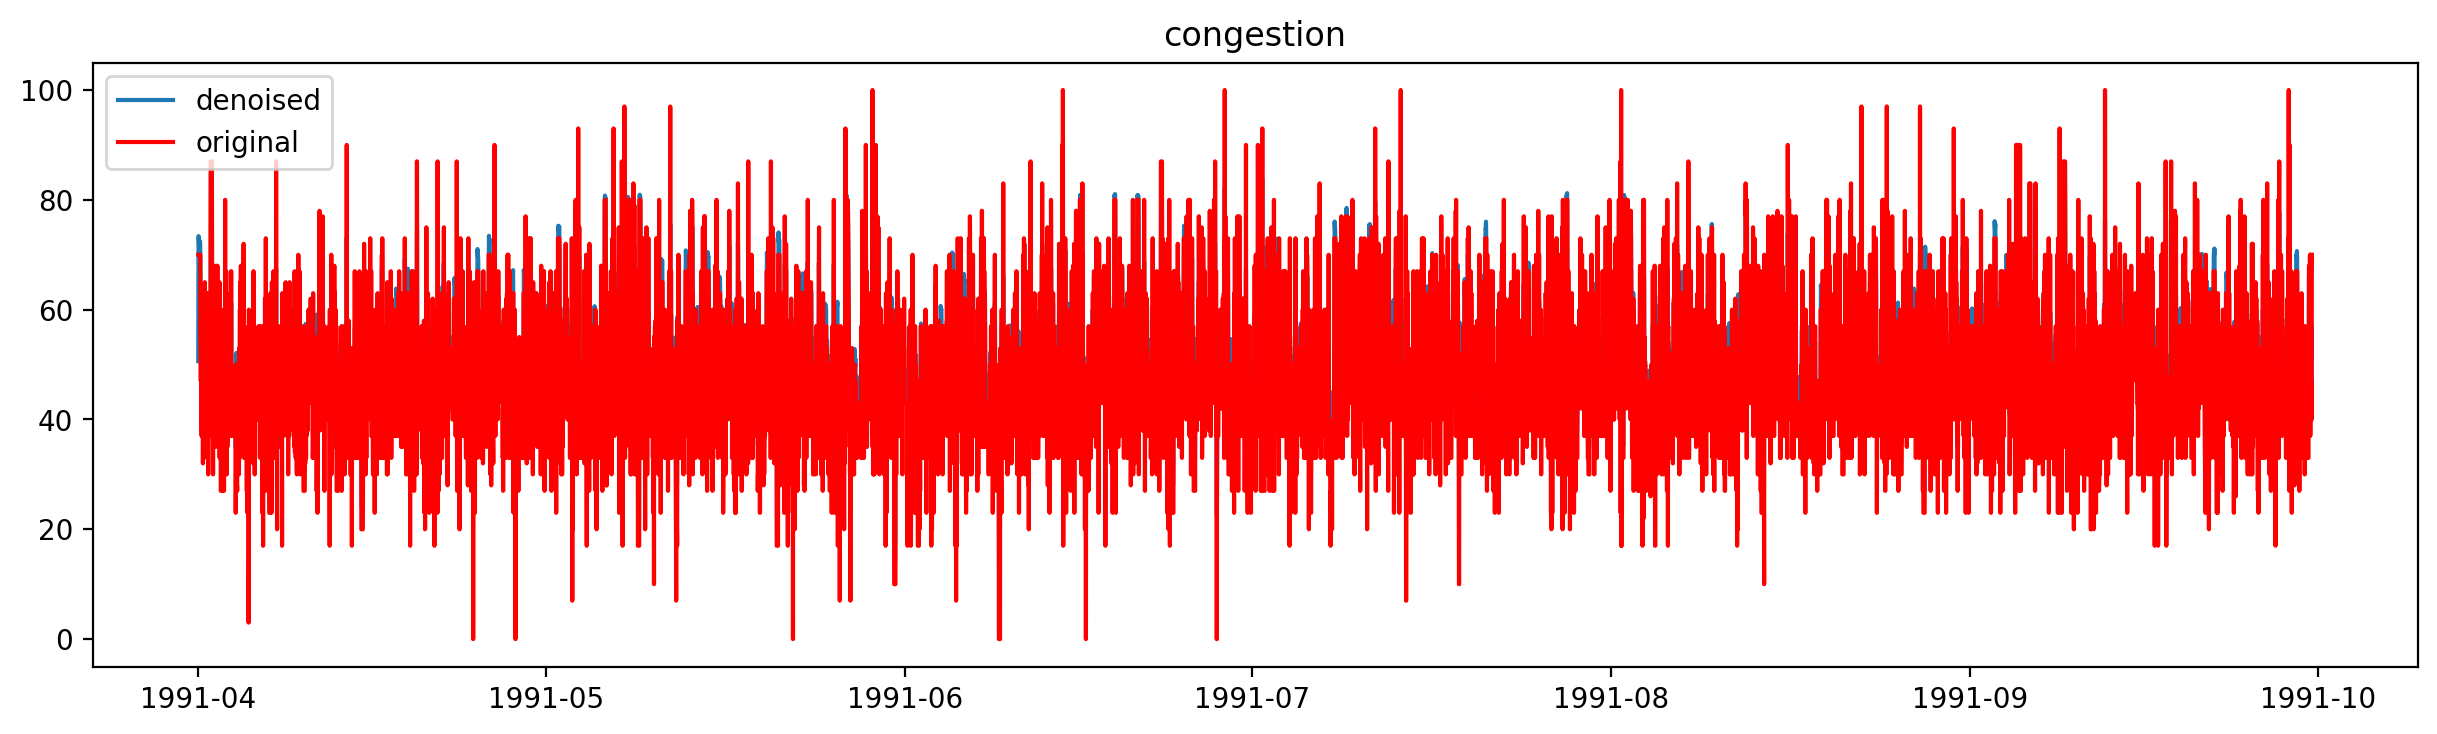

In [17]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['congestion'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['congestion'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['congestion'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('congestion')
plt.legend(['denoised', 'original'], loc='upper left')

In [18]:
original=GSPC_test
recon=pure_mm_cnn

In [19]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['congestion'].shift(i)
    return ret_dataset

In [20]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

74.83212511061959
72.51384857786144
62.971144777887936
61.603866140000385
65.50102621604422
55.62782951997414
54.07059411990655
52.16016517701936
67.58241640409905
48.467099128593446
The last MSE: 48.467099128593446
The average MSE: 61.53301151720061


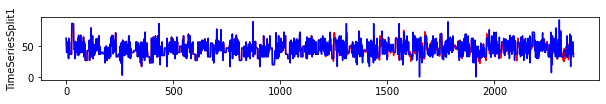

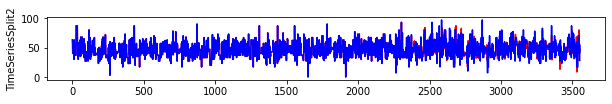

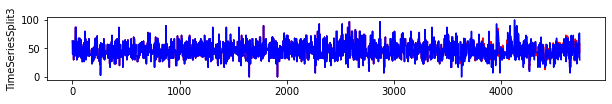

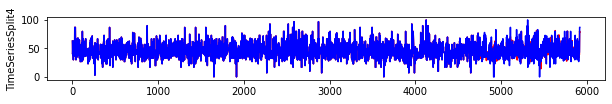

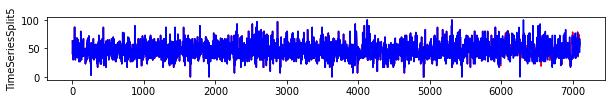

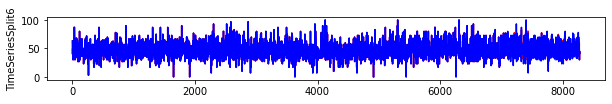

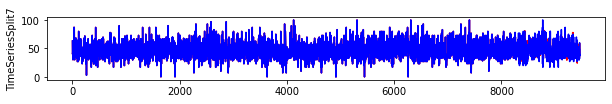

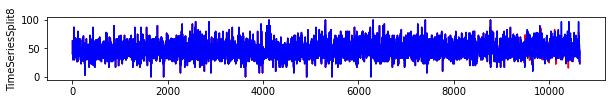

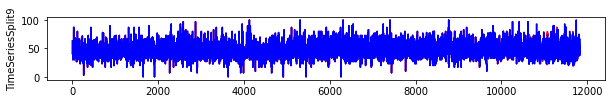

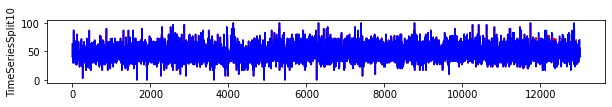

In [21]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [22]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [23]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -33.37    |  0.7933   |  0.4462   |  0.01902  |  15.83    |  0.2328   |  403.3    |  0.8479   |  0.4283   |  0.5342   |  0.9606   |
|  2        | -27.33    |  0.9618   |  0.8662   |  0.03481  |  5.873    |  0.5001   |  175.9    |  0.7703   |  0.2794   |  0.6954   |  0.7203   |
|  3        | -36.1     |  0.6172   |  0.9214   |  0.2664   |  3.702    |  1.986    |  413.6    |  0.3096   |  0.5309   |  0.9503   |  0.5044   |
|  4        | -29.46    |  0.8874   |  0.0936   |  0.02558  |  10.81    |  1.246    |  988.2    |  0.9727   |  0.2797   |  0.8772   |  0.5091   |
|  5        | -43.39    |  0.9421   |  0.6591   |  0.2439   |  17.88    |  0.7745   |  967.2    |  0.4815   |  0.2484   |  0

{'target': -26.54082489013672,
 'params': {'colsample_bytree': 0.9069562375494677,
  'gamma': 0.48314010610329505,
  'learning_rate': 0.04245407837925432,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 176,
  'reg_alpha': 0.37113505243075273,
  'reg_lambda': 0.6923340845518227,
  'scale_pos_weight': 0.5401139144380489,
  'subsample': 0.9531811460220938}}

137.763143359284
144.20577077663714
150.52427140543386
153.4263065419378
150.5686064950522
131.7641879786687
127.68075646363324
134.34377344696546
152.28760845960136
124.23597242474737
The last MSE: 124.23597242474737
The average MSE: 140.68003973519612


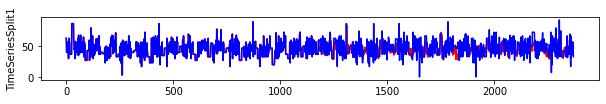

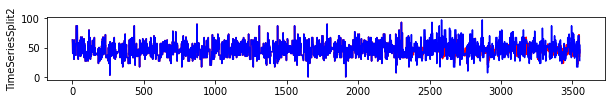

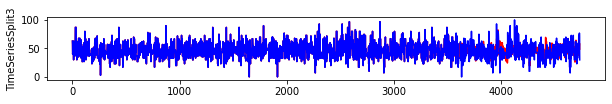

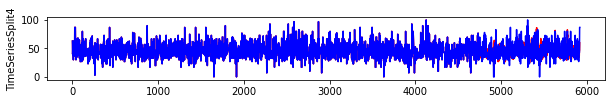

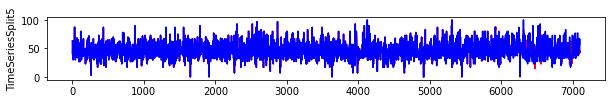

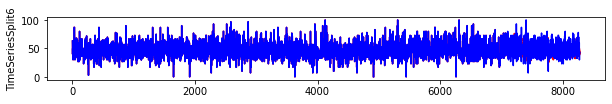

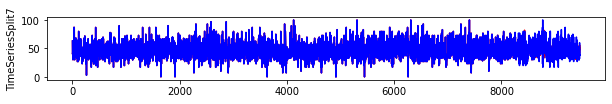

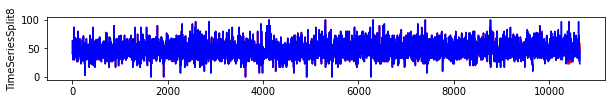

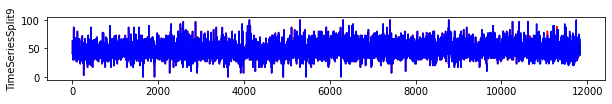

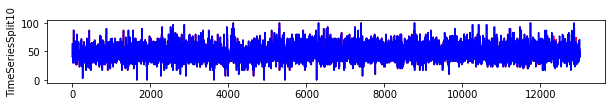

In [25]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [26]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [27]:
rf_bo = BayesianOptimization(
        rf_oo,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -118.4    |  0.822    |  0.5327   |  0.03045  |  9.447    |  0.974    |  635.3    |  0.4933   |  0.283    |  0.3236   |  0.9077   |
|  2        | -121.7    |  0.701    |  0.3324   |  0.06452  |  8.337    |  1.541    |  833.7    |  0.3175   |  0.647    |  0.7779   |  0.7789   |
|  3        | -123.9    |  0.9696   |  0.3065   |  0.09468  |  15.93    |  1.501    |  736.3    |  0.05497  |  0.9803   |  0.2078   |  0.9364   |
|  4        | -150.8    |  0.5401   |  0.4205   |  0.2131   |  15.04    |  0.5375   |  734.2    |  0.6254   |  0.6643   |  0.8812   |  0.5365   |
|  5        | -134.8    |  0.609    |  0.9251   |  0.183    |  7.416    |  0.1203   |  415.5    |  0.3093   |  0.3463   |  0

{'target': -117.81696439435855,
 'params': {'colsample_bytree': 0.9731020301333353,
  'gamma': 0.4098516293628097,
  'learning_rate': 0.2387011239533171,
  'max_depth': 1,
  'min_child_weight': 1,
  'n_estimators': 466,
  'reg_alpha': 0.3983778384494669,
  'reg_lambda': 0.3649310088050295,
  'scale_pos_weight': 0.4237505561049842,
  'subsample': 0.8553592679397202}}

# EMDCNN

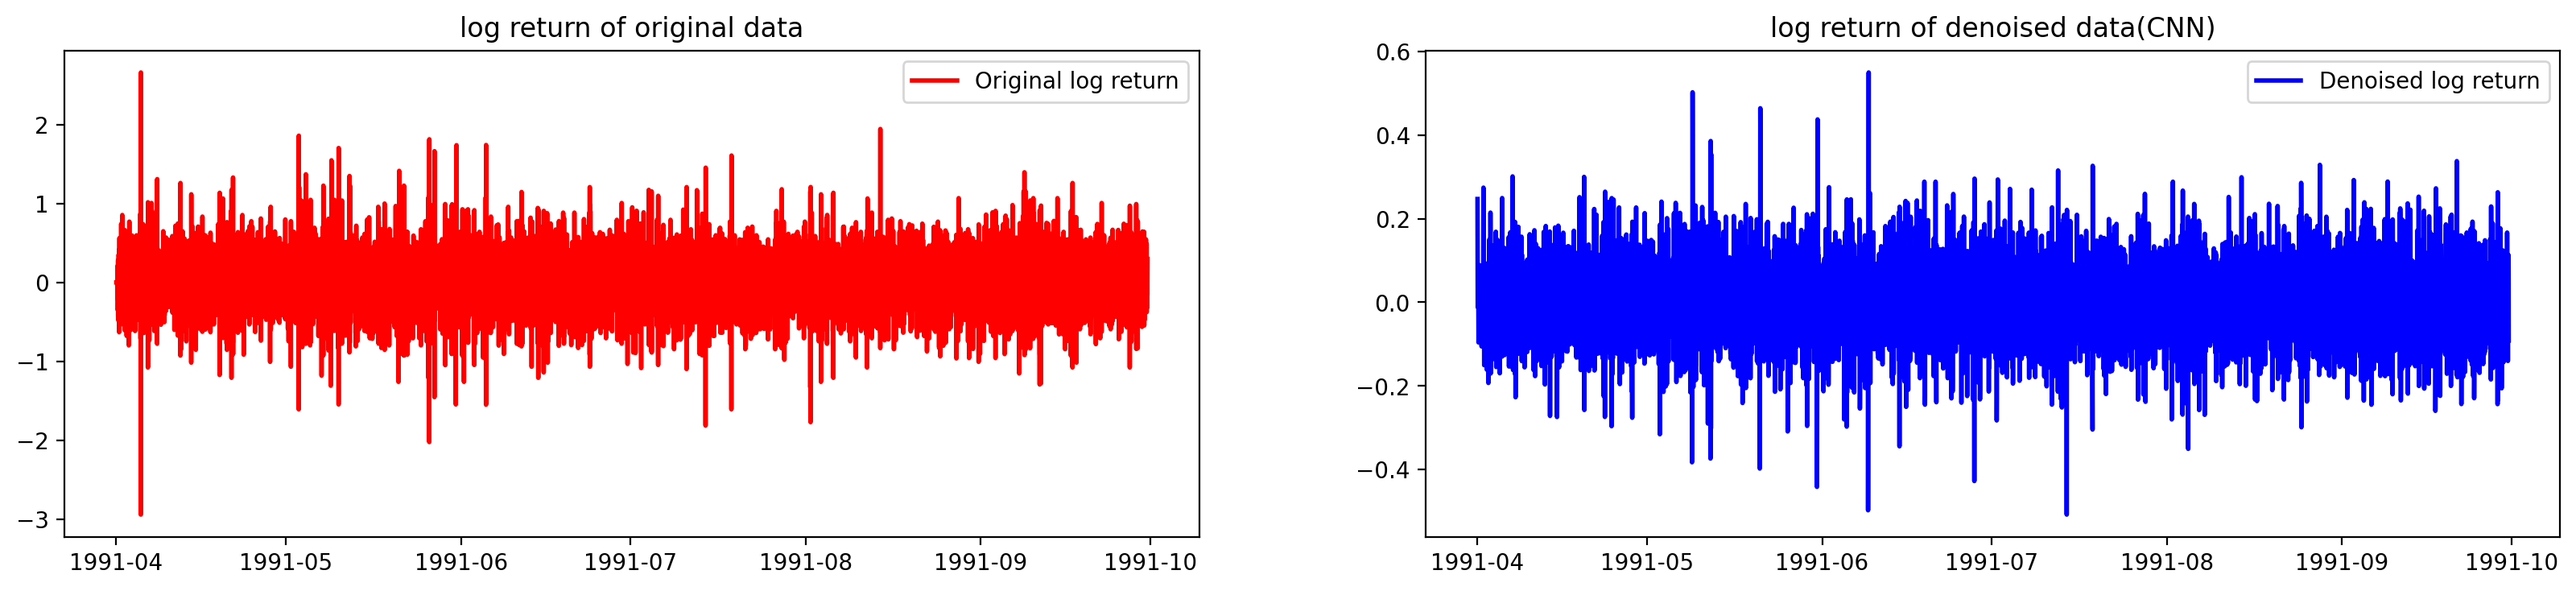

In [24]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
#plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
#plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [25]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/20):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/20):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [26]:

GSPC_test_n['log_ret'][np.isinf(GSPC_test_n['log_ret'])] = 99
pure_mm_cnn['log_ret'][np.isinf(pure_mm_cnn['log_ret'])] = 99
GSPC_test_n=GSPC_test_n.fillna(0)
pure_mm_cnn=pure_mm_cnn.fillna(0)


In [27]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

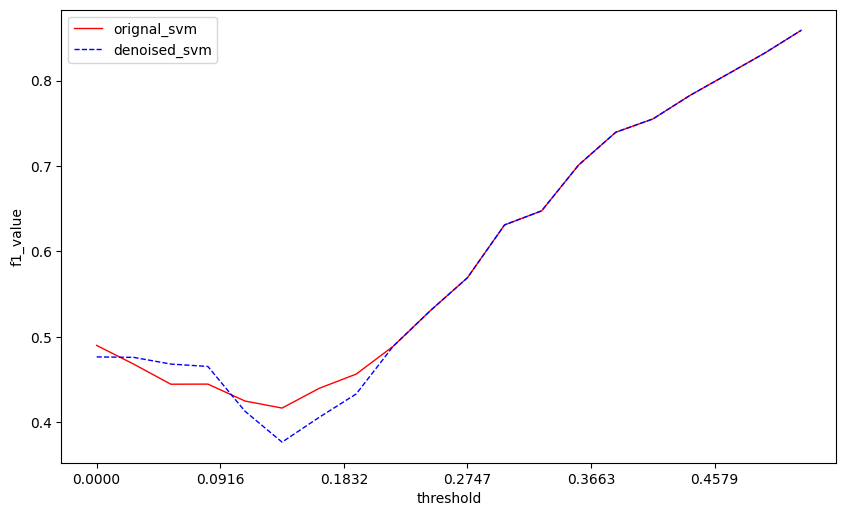

In [28]:
plt.figure(figsize=(10,6),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [29]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=10,percentage=1)

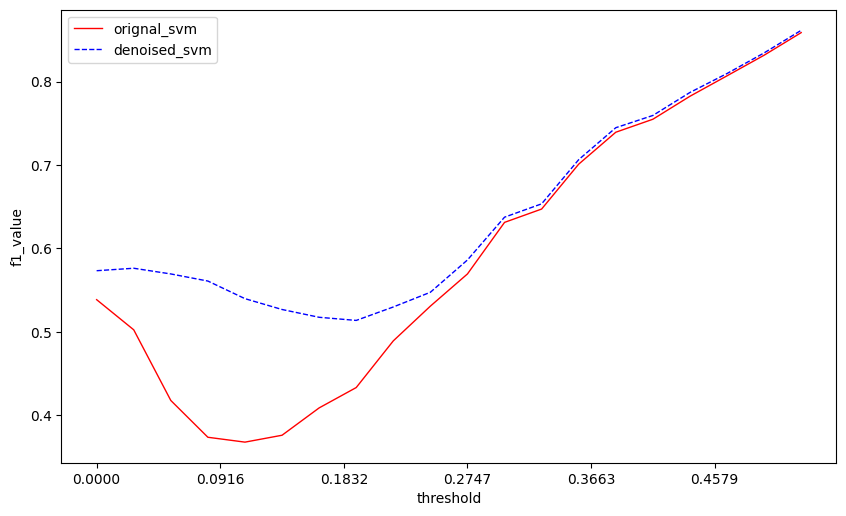

In [30]:
plt.figure(figsize=(10,6),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Only emd

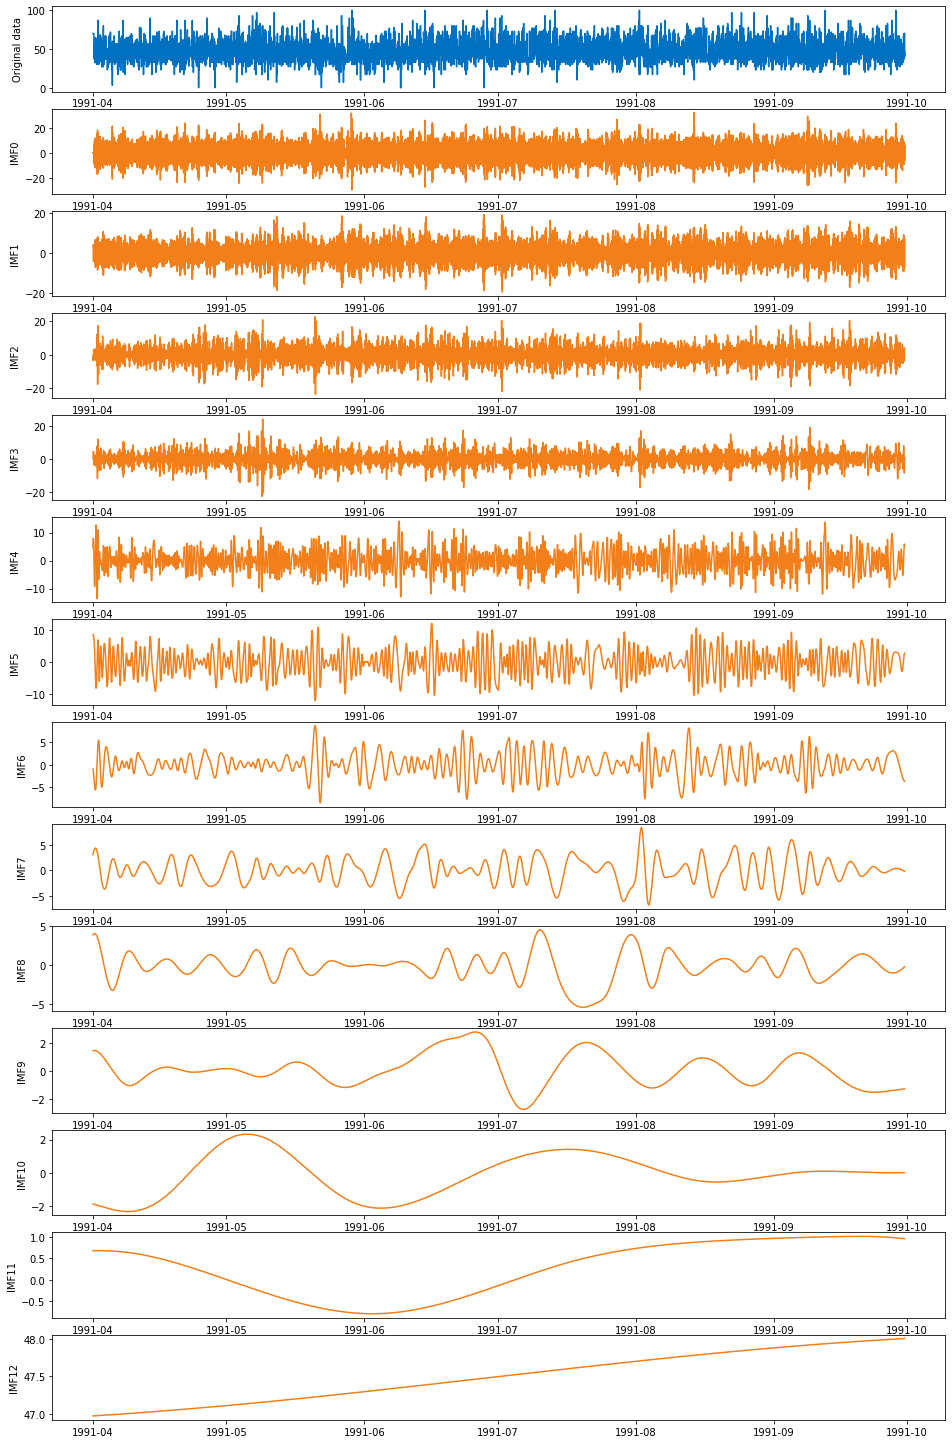

In [31]:
emdre=emd_calculate(EB00)
reedm=reconstruction(emdre)

In [32]:
pure_mm_cnn=pd.DataFrame(reedm.iloc[1,:]).rename(columns={'sum1':'congestion'})
pure_mm_cnn

,congestion
time,
1991-04-01 00:00:00,69.899153
1991-04-01 00:20:00,70.319646
1991-04-01 00:40:00,70.321320
1991-04-01 01:00:00,70.151078
1991-04-01 01:20:00,69.887312
...,...
1991-09-30 10:20:00,42.878194
1991-09-30 10:40:00,40.736246
1991-09-30 11:00:00,46.153304


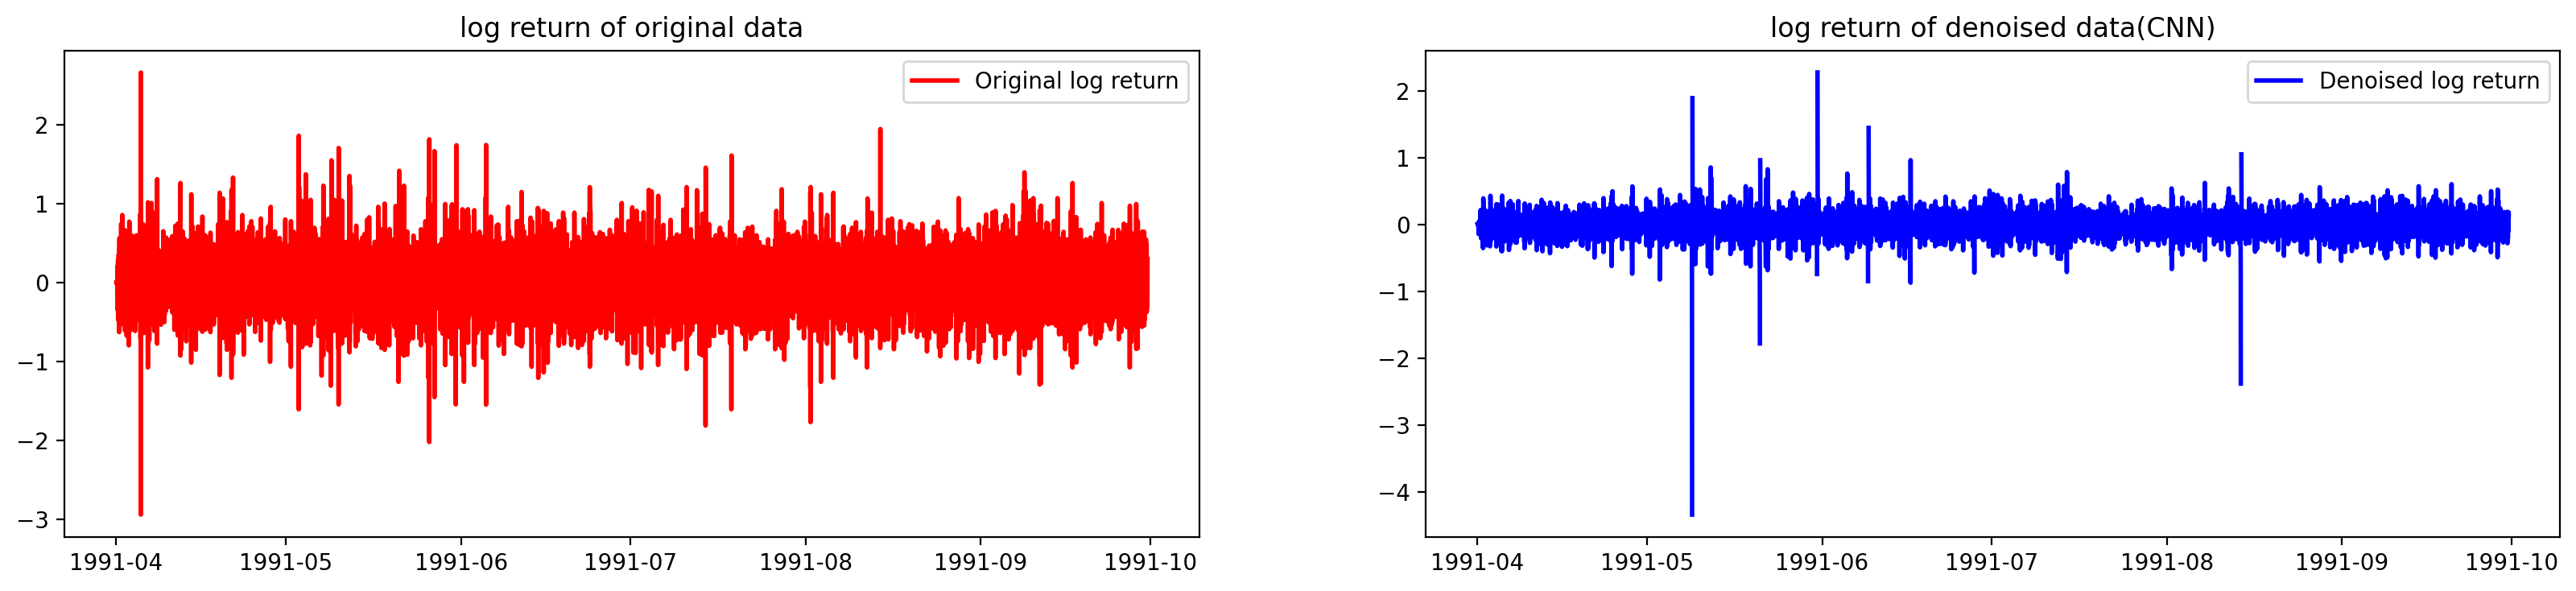

In [33]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')

plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')

plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [36]:
original=pd.DataFrame(GSPC_test['congestion'])
recon=pd.DataFrame(pure_mm_cnn['congestion'])

In [37]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['congestion'].shift(i)
    return ret_dataset

In [38]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

105.54068343039447
100.51910831768762
93.11022279529419
99.87211457414915
100.85006461529461
89.31458085211172
84.3462510950968
79.63199466538038
107.61292961447387
78.67920820624387
The last MSE: 78.67920820624387
The average MSE: 93.94771581661266


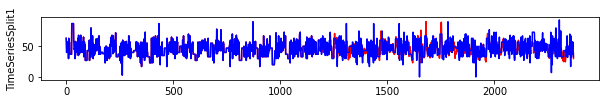

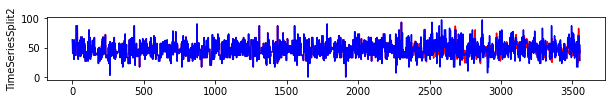

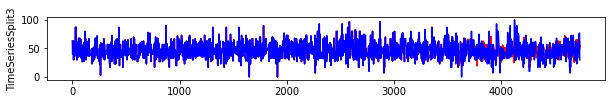

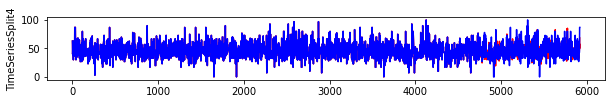

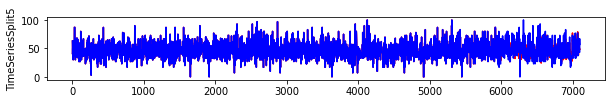

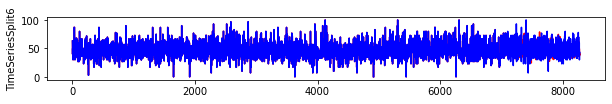

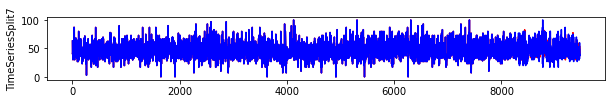

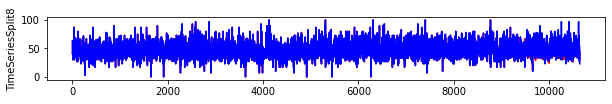

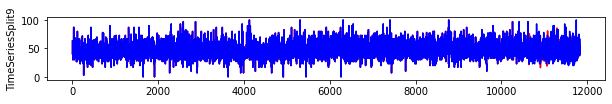

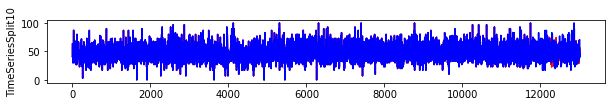

In [39]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

137.763143359284
144.20577077663714
150.52427140543386
153.4263065419378
150.5686064950522
131.7641879786687
127.68075646363324
134.34377344696546
152.28760845960136
124.23597242474737
The last MSE: 124.23597242474737
The average MSE: 140.68003973519612


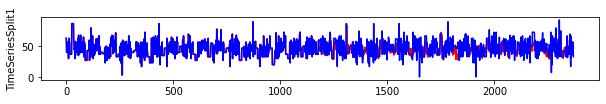

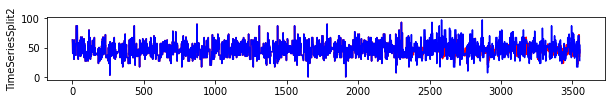

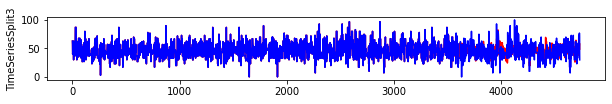

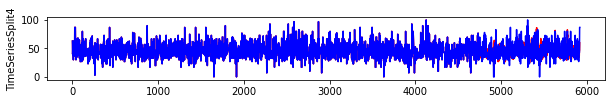

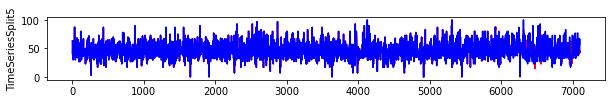

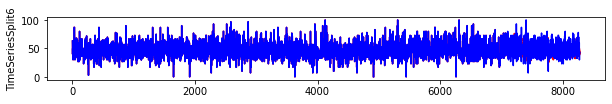

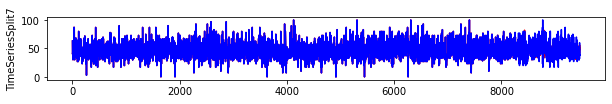

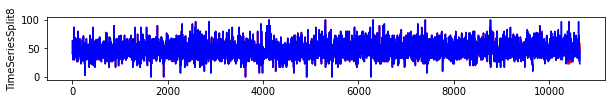

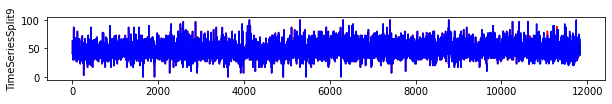

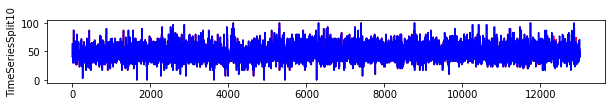

In [40]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [34]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/20):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/20):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [35]:
GSPC_test_n['log_ret'][np.isinf(GSPC_test_n['log_ret'])] = 99
pure_mm_cnn['log_ret'][np.isinf(pure_mm_cnn['log_ret'])] = 99
GSPC_test_n=GSPC_test_n.fillna(0)
pure_mm_cnn=pure_mm_cnn.fillna(0)

In [36]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1)

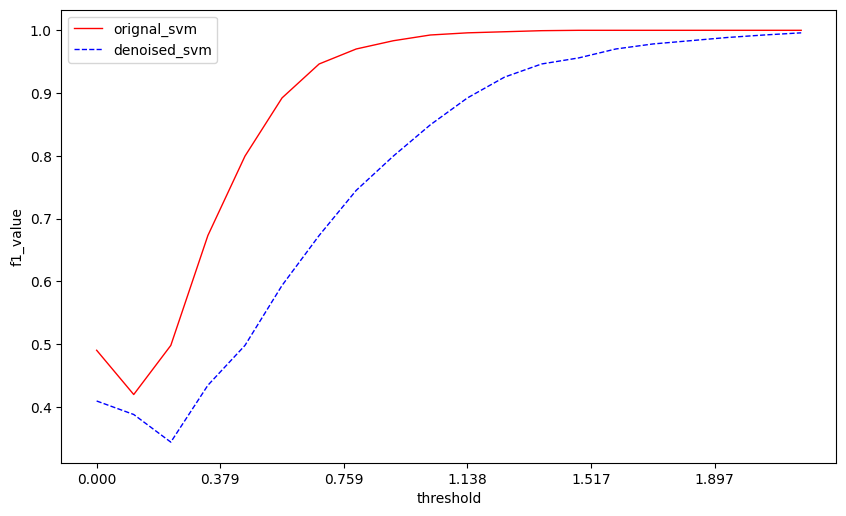

In [38]:
plt.figure(figsize=(10,6),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [39]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=10)

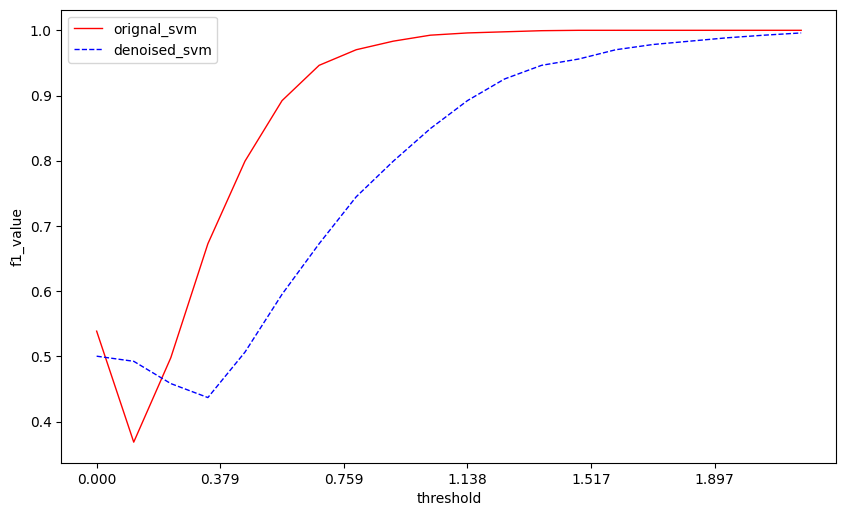

In [41]:
plt.figure(figsize=(10,6),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()